ライブラリ

In [68]:
import os, sys
from typing import List, Tuple
# データ処理
import numpy as np
import pandas as pd
# お絵かき
import matplotlib.pyplot as plt
import seaborn as sns
# 前処理
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn_pandas import DataFrameMapper
# データ分割
from sklearn.model_selection import train_test_split
# モデル
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
# スコア
from sklearn.metrics import roc_auc_score, roc_curve
# 交差検証
from sklearn.model_selection import KFold, StratifiedKFold
# ハイパーパラメターチューニング
import optuna
# ガベージコレクタ
import gc

データ取得

In [2]:
# print(os.listdir("../data/"))
PATH_APPLICATION = r"../data/application.csv"
PATH_TRAIN_KEY   = r"../data/train_key.csv"

In [3]:
df_application = pd.read_csv(PATH_APPLICATION)
df_tr_key = pd.read_csv(PATH_TRAIN_KEY)

In [4]:
app_train = pd.merge(df_application, df_tr_key, on = "SK_ID_CURR")

# データチェック

- 目的変数の分布

    不均衡データ -> 取り扱い要相談

0    282686
1     24825
Name: TARGET, dtype: int64


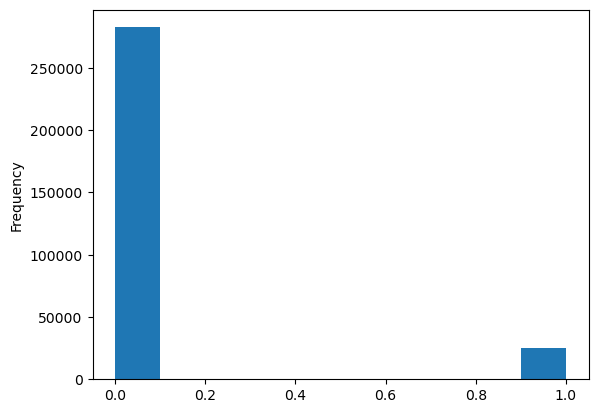

In [5]:
print(df_tr_key["TARGET"].value_counts())
df_tr_key["TARGET"].plot.hist()
plt.show()

- 欠損データのチェック

    要相談

In [6]:
def check_missing_values(df:pd.DataFrame) -> pd.DataFrame:
        # 欠損値の合計
        mis_val = df.isnull().sum()
        # 欠損値の割合
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        # 欠損値のテーブル作成
        df_mis_val = pd.concat([mis_val, mis_val_percent], axis=1)\
                       .rename(columns = {0 : 'Missing Values',\
                                          1 : '% of Total Values'})
        df_mis_val = df_mis_val[df_mis_val.iloc[:,1] != 0]\
                               .sort_values('% of Total Values', ascending=False)\
                               .round(2)
        
        print("{1} / {0} のカラムに欠損値がありました．".format(df.shape[1], df_mis_val.shape[0]))
        return df_mis_val

In [7]:
df_mis_val = check_missing_values(app_train)

67 / 122 のカラムに欠損値がありました．


In [8]:
df_mis_val.head()

,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.87
COMMONAREA_AVG,214865,69.87
COMMONAREA_MODE,214865,69.87
NONLIVINGAPARTMENTS_MEDI,213514,69.43
NONLIVINGAPARTMENTS_MODE,213514,69.43


- カラムのタイプ

In [9]:
# 型ごとのカラム数
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [10]:
# それぞれのobjectカラムにあるカテゴリ
app_train.select_dtypes("object")\
         .apply(pd.Series.unique, axis = 0)

NAME_CONTRACT_TYPE                                [Cash loans, Revolving loans]
CODE_GENDER                                                         [M, F, XNA]
FLAG_OWN_CAR                                                             [N, Y]
FLAG_OWN_REALTY                                                          [Y, N]
NAME_TYPE_SUITE               [Unaccompanied, Family, Spouse, partner, Child...
NAME_INCOME_TYPE              [Working, State servant, Commercial associate,...
NAME_EDUCATION_TYPE           [Secondary / secondary special, Higher educati...
NAME_FAMILY_STATUS            [Single / not married, Married, Civil marriage...
NAME_HOUSING_TYPE             [House / apartment, Rented apartment, With par...
OCCUPATION_TYPE               [Laborers, Core staff, Accountants, Managers, ...
WEEKDAY_APPR_PROCESS_START    [WEDNESDAY, MONDAY, THURSDAY, SUNDAY, SATURDAY...
ORGANIZATION_TYPE             [Business Entity Type 3, School, Government, R...
FONDKAPREMONT_MODE            [reg oper 

In [11]:
# それぞれのobjectカラムにあるカテゴリの数
app_train.select_dtypes("object")\
         .apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

- アノマリ検出

In [12]:
# 応募時の年齢（デフォルトは日齢）
(app_train["DAYS_BIRTH"] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [13]:
# 申し込みの何日前に登録を変更したか
app_train["DAYS_REGISTRATION"].describe()

count    307511.000000
mean      -4986.120328
std        3522.886321
min      -24672.000000
25%       -7479.500000
50%       -4504.000000
75%       -2010.000000
max           0.000000
Name: DAYS_REGISTRATION, dtype: float64

In [14]:
# 申し込みの何日前に本人確認書類を変更したか
app_train["DAYS_ID_PUBLISH"].describe()

count    307511.000000
mean      -2994.202373
std        1509.450419
min       -7197.000000
25%       -4299.000000
50%       -3254.000000
75%       -1720.000000
max           0.000000
Name: DAYS_ID_PUBLISH, dtype: float64

In [15]:
# 就職してから応募時点までの日数
app_train["DAYS_EMPLOYED"].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

In [16]:
# 最大値がおかしい ...→でもデフォルトには効いている→ とりあえず異常値は欠損値にする
anom = app_train.query("DAYS_EMPLOYED == 365243")
non_anom = app_train.query("DAYS_EMPLOYED != 365243")
print("通常データのうち{}%がデフォルト".format(100 * non_anom["TARGET"].mean()))
print("異常データのうち{}%がデフォルト".format(100 * anom["TARGET"].mean()))

通常データのうち8.65997453765215%がデフォルト
異常データのうち5.399646043269405%がデフォルト


In [17]:
# 異常値を欠損値にした
app_train["DAYS_EMPLOYED_ANOM"] = app_train["DAYS_EMPLOYED"] == 365243
app_train["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

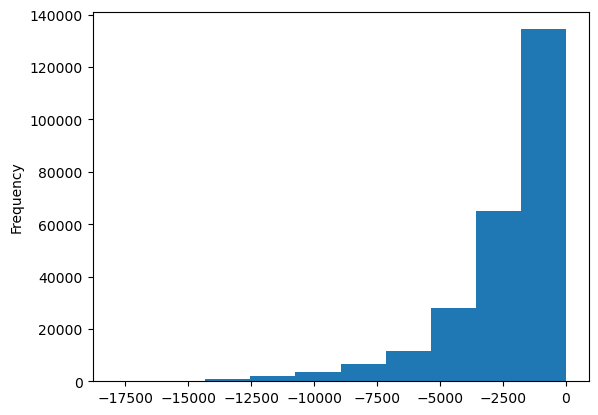

In [18]:
app_train["DAYS_EMPLOYED"].plot.hist()
plt.show()

- 目的変数との相関，Spearman順位相関

    DAYS_BIRTH, EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3が相関高め

In [19]:
correlations = app_train.corr()["TARGET"].sort_values(ascending = False)
spearmans = app_train.corr(method="spearman")["TARGET"].sort_values(ascending = False)

In [24]:
print("TOP5:\n", correlations.head(5))
print("BOTTOM5:\n", correlations.tail(5))

TOP5:
 TARGET                         1.000000
DAYS_BIRTH                     0.078239
DAYS_EMPLOYED                  0.074958
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
Name: TARGET, dtype: float64
BOTTOM5:
 FLOORSMAX_AVG        -0.044003
DAYS_EMPLOYED_ANOM   -0.045987
EXT_SOURCE_1         -0.155317
EXT_SOURCE_2         -0.160472
EXT_SOURCE_3         -0.178919
Name: TARGET, dtype: float64


In [21]:
print("TOP5:\n", spearmans.head(5))
print("BOTTOM5:\n", spearmans.tail(5))

TOP5 TARGET                         1.000000
DAYS_EMPLOYED                  0.080271
DAYS_BIRTH                     0.078328
REGION_RATING_CLIENT_W_CITY    0.060936
REGION_RATING_CLIENT           0.058909
Name: TARGET, dtype: float64
BOTTOM5 FLOORSMAX_MEDI   -0.046019
FLOORSMAX_AVG    -0.046178
EXT_SOURCE_2     -0.147332
EXT_SOURCE_1     -0.151128
EXT_SOURCE_3     -0.166330
Name: TARGET, dtype: float64


- 年齢層ごとのデフォルト率を見てみる
    
    若年層のデフォルト率が高い

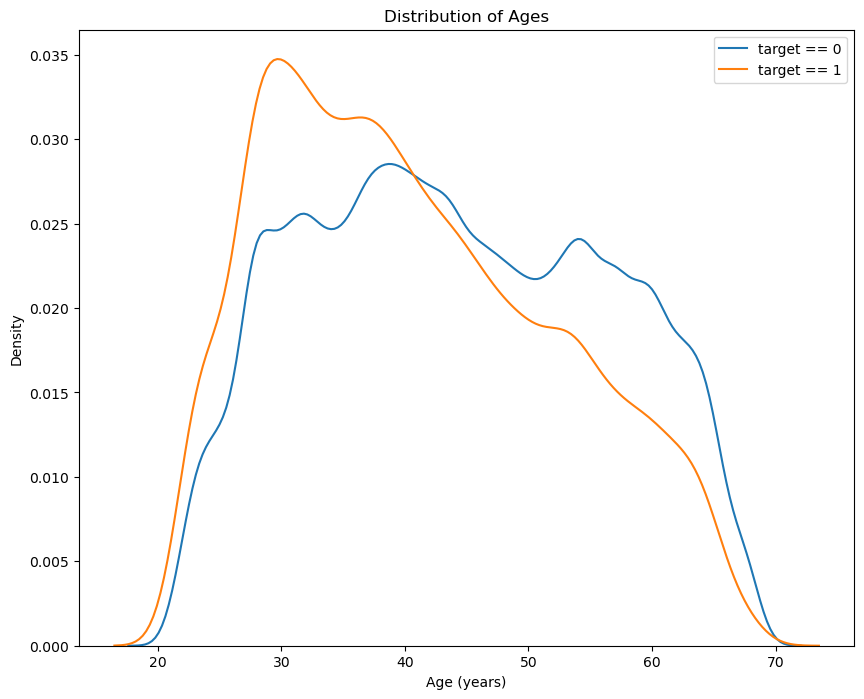

In [42]:
plt.figure(figsize = (10, 8))
# KDEプロット（カーネル密度推定）
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / -365, label = 'target == 0')
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / -365, label = 'target == 1')
plt.xlabel('Age (years)')
plt.ylabel('Density')
plt.title('Distribution of Ages')
plt.legend()
plt.show()

In [67]:
age_data = app_train[["TARGET", "DAYS_BIRTH"]]
age_data["YEARS_BIRTH"] = age_data["DAYS_BIRTH"] / -365
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))

<ipython-input-67-89155764a44b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_data["YEARS_BIRTH"] = age_data["DAYS_BIRTH"] / -365
<ipython-input-67-89155764a44b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))


In [50]:
age_groups = age_data.groupby("YEARS_BINNED").mean()

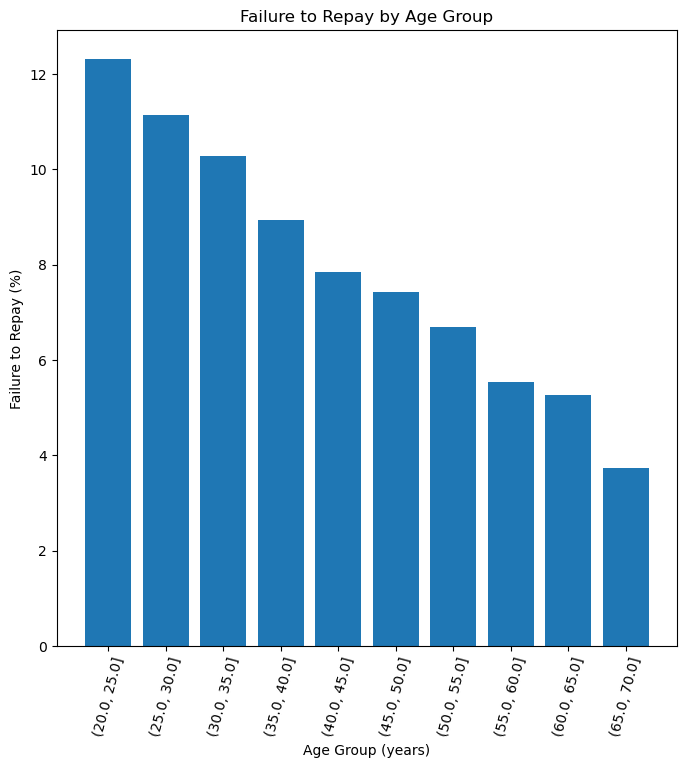

In [53]:
plt.figure(figsize = (8, 8))
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group')
plt.show()

- EXT_SOURCEs

In [60]:
# 改めて相関
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,-0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,-0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,-0.205478
DAYS_BIRTH,0.078239,-0.600610,-0.091996,-0.205478,1.000000


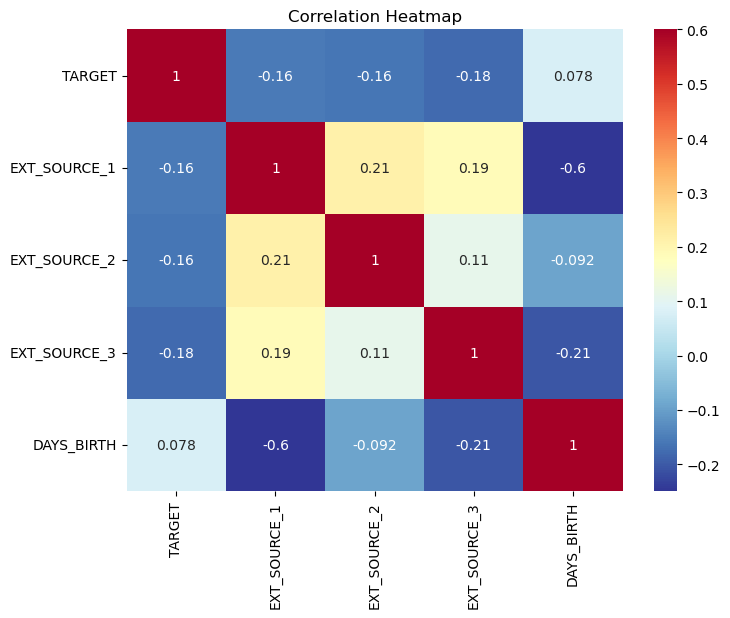

In [61]:
plt.figure(figsize = (8, 6))
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap')
plt.show()

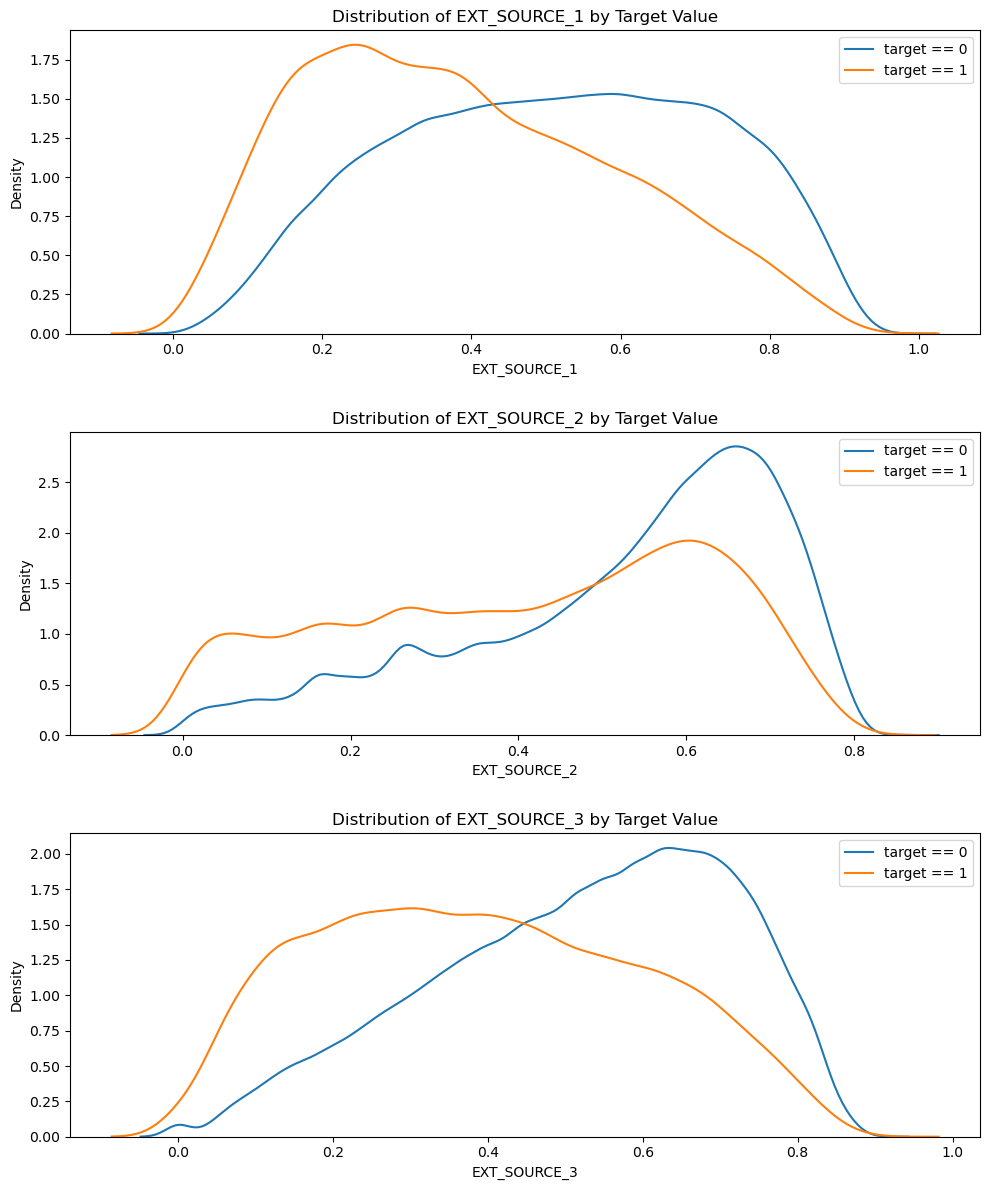

In [76]:
plt.figure(figsize = (10, 12))
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    plt.subplot(3, 1, i + 1)
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel(f'{source}')
    plt.ylabel('Density')
    plt.legend()
plt.tight_layout(h_pad = 2.5)
plt.show()

特徴量作成
（参考：https://www.kaggle.com/jsaguiar/lightgbm-with-simple-features?scriptVersionId=6025993 ）

In [69]:
app_train_domain = app_train.copy()
app_train_domain['DAYS_EMPLOYED_PERC'] = app_train['DAYS_EMPLOYED'] / app_train['DAYS_BIRTH']
app_train_domain['INCOME_CREDIT_PERC'] = app_train['AMT_INCOME_TOTAL'] / app_train['AMT_CREDIT']
app_train_domain['INCOME_PER_PERSON'] = app_train['AMT_INCOME_TOTAL'] / app_train['CNT_FAM_MEMBERS']
app_train_domain['ANNUITY_INCOME_PERC'] = app_train['AMT_ANNUITY'] / app_train['AMT_INCOME_TOTAL']
app_train_domain['PAYMENT_RATE'] = app_train['AMT_ANNUITY'] / app_train['AMT_CREDIT']

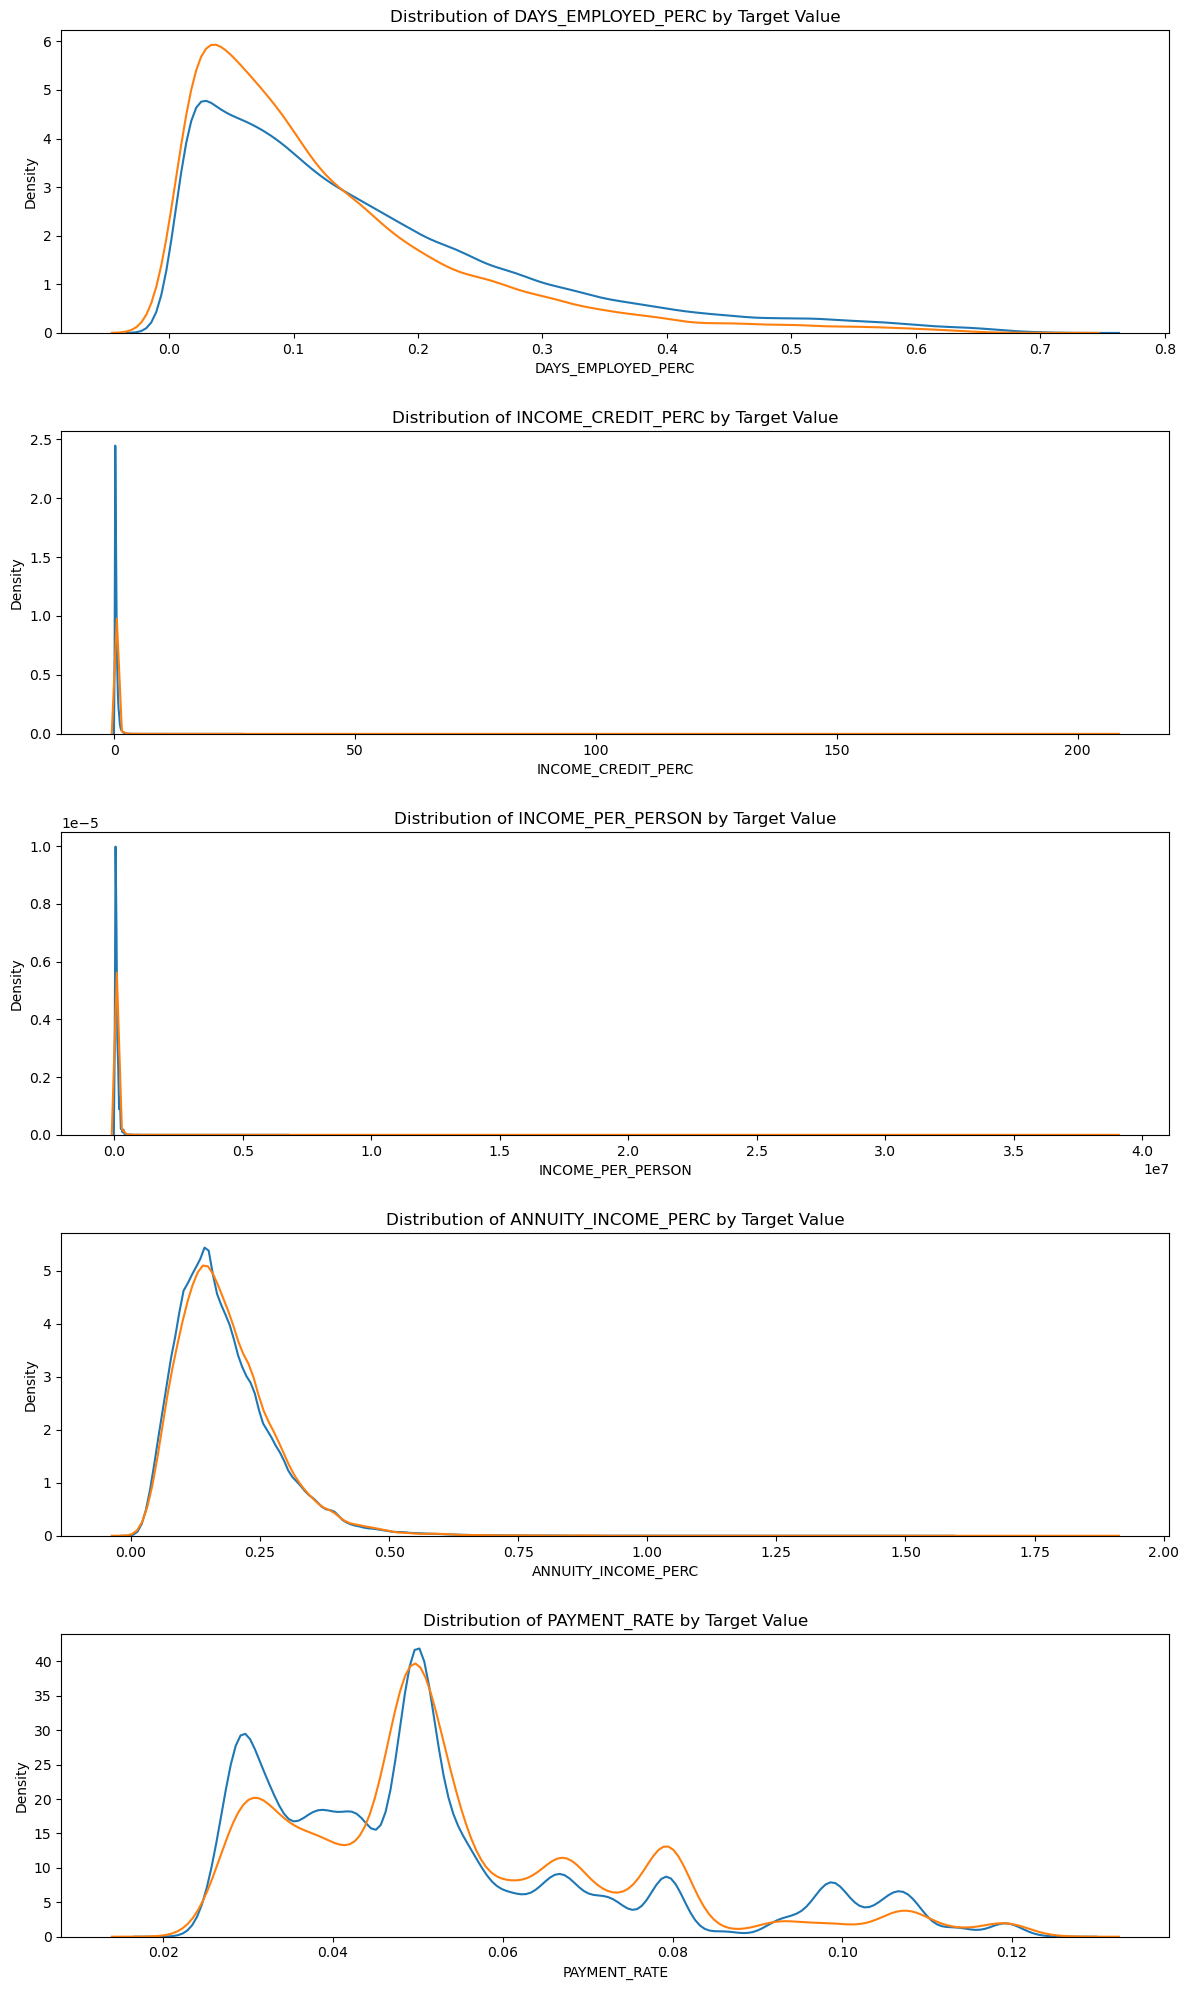

In [75]:
plt.figure(figsize = (12, 20))
for i, feature in enumerate(['DAYS_EMPLOYED_PERC', 'INCOME_CREDIT_PERC', 'INCOME_PER_PERSON',\
                             'ANNUITY_INCOME_PERC', 'PAYMENT_RATE']):
    plt.subplot(5, 1, i + 1)

    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target == 0')
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'target == 1')
    
    plt.title(f'Distribution of {feature} by Target Value')
    plt.xlabel(f'{feature}')
    plt.ylabel('Density')
plt.tight_layout(h_pad = 2.5)
plt.show()